In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression

import scipy.stats as st
import statsmodels as sm
import scipy.optimize as opt
import scipy

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [100]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

In [101]:
gaz = pd.read_csv(os.path.join("Futures", "Daily_Natural_Gas_Futures_Contract_1.csv"), skiprows=5, parse_dates=['Data'], names=["Data", "Cena gazu [USD/Million Btu]"])
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()

In [102]:
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]

In [103]:
ropa = ropa.astype({"Data": "datetime64[ns]"})

# Za zmienną ryzyka systemowego przyjmujemy kurs USD/PLN

In [104]:
usdpln_csv = pd.read_csv("usdpln.csv")
usdpln = pd.DataFrame()
usdpln["Data"] = usdpln_csv["Data"]
usdpln["Kurs USD/PLN"] = usdpln_csv["Zamkniecie"]

In [105]:
usdpln = usdpln.astype({"Data": "datetime64[ns]"})

In [106]:
df = gaz.merge(ropa, on="Data", how="inner").dropna()
df = df.sort_values(['Data'], ascending=[True])
df

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel]
3872,2007-07-30,6.4990,75.7400
3871,2007-07-31,6.1910,77.0500
3870,2007-08-01,6.3520,75.3500
3869,2007-08-02,6.1060,75.7600
3868,2007-08-03,6.0900,74.7500
...,...,...,...
4,2023-04-03,2.0970,84.9300
3,2023-04-04,2.1060,84.9400
2,2023-04-05,2.1550,84.9900
1,2023-04-10,2.1720,84.1800


In [107]:
df2 = df.merge(usdpln, on="Data", how="inner").dropna()
df2

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel],Kurs USD/PLN
0,2007-07-30,6.4990,75.7400,2.7706
1,2007-07-31,6.1910,77.0500,2.7667
2,2007-08-01,6.3520,75.3500,2.7751
3,2007-08-02,6.1060,75.7600,2.7676
4,2007-08-03,6.0900,74.7500,2.7486
...,...,...,...,...
3847,2023-04-03,2.0970,84.9300,4.2868
3848,2023-04-04,2.1060,84.9400,4.2706
3849,2023-04-05,2.1550,84.9900,4.2968
3850,2023-04-10,2.1720,84.1800,4.3157


# Ceny od 2017

In [124]:
mask = df2["Data"] > '2017-01-01'
df_merge = df2.loc[mask]
y_gaz = df_merge['Cena gazu [USD/Million Btu]']
y_ropa = df_merge['Cena ropy [USD/Barrel]']
y_usdpln = df_merge['Kurs USD/PLN']

In [125]:
df_final = pd.DataFrame()
df_final['Data'] = df_merge['Data']
df_final['przyrosty_log_gaz'] = np.log(y_gaz).diff()
df_final['przyrosty_log_ropa'] = np.log(y_ropa).diff()
df_final['przyrosty_log_usdpln'] = np.log(y_usdpln).diff()
df_final = df_final.dropna()

In [126]:
df_final = df_final.reset_index(drop=True)
df_final.head()

,Data,przyrosty_log_gaz,przyrosty_log_ropa,przyrosty_log_usdpln
0,2017-01-04,-0.0182,0.0177,-0.0117
1,2017-01-05,0.0018,0.0076,-0.0118
2,2017-01-06,0.0037,0.0037,0.0045
3,2017-01-09,-0.0570,-0.0386,0.0009
4,2017-01-10,0.0549,-0.0239,0.0006


## Wizualizacja danych

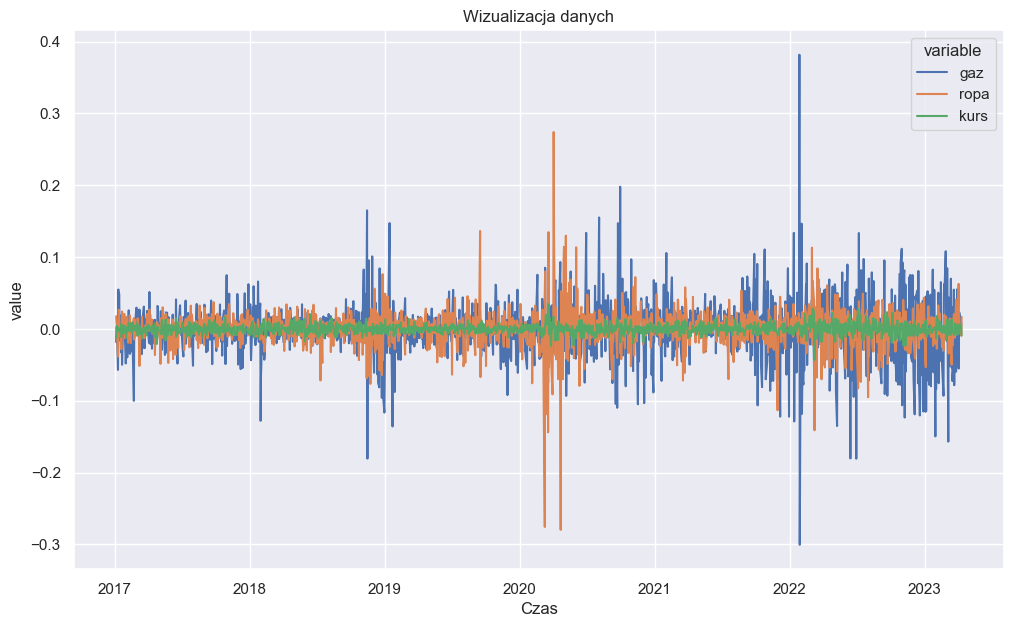

In [129]:
data_preproc = pd.DataFrame({
    'Data': df_final['Data'], 
    'gaz': df_final['przyrosty_log_gaz'],
    'ropa': df_final['przyrosty_log_ropa'],
    'kurs': df_final['przyrosty_log_usdpln']})

sns.lineplot(x='Data', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Data']))
plt.title('Wizualizacja danych')
plt.xlabel('Czas')
plt.show()

## Macierz korelacji

C:\Users\user\AppData\Local\Temp\ipykernel_30624\3745121201.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_final.corr()


<AxesSubplot: >

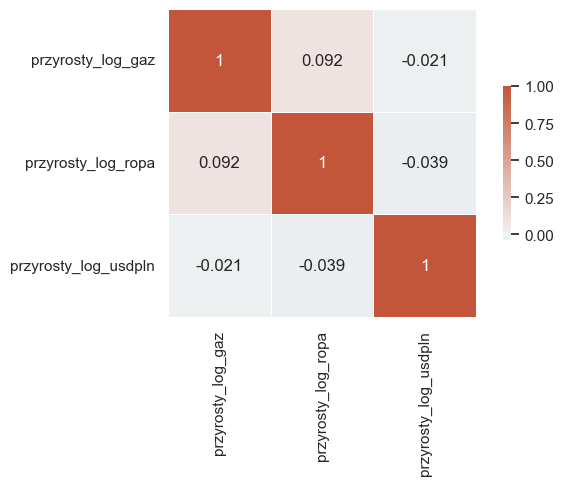

In [134]:
corr = df_final.corr()

f, ax = plt.subplots(figsize=(7, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap,
            annot=True,
            center=0,
            vmax=1,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

### Przesunięcie wartości indeksu w czasie o 1 dzień
czyli jak wczorajsza cena kursu USD/PLN wpływa na dzisiejsze ceny ropy i gazu

In [145]:
k = 1

df_moved = pd.DataFrame()
df_moved['przyrosty_log_gaz'] = df_final['przyrosty_log_gaz'][k:]
df_moved['przyrosty_log_ropa'] = df_final['przyrosty_log_ropa'][k:]
df_moved['przyrosty_log_usdpln'] = df_final['przyrosty_log_usdpln'][:-k]

<AxesSubplot: >

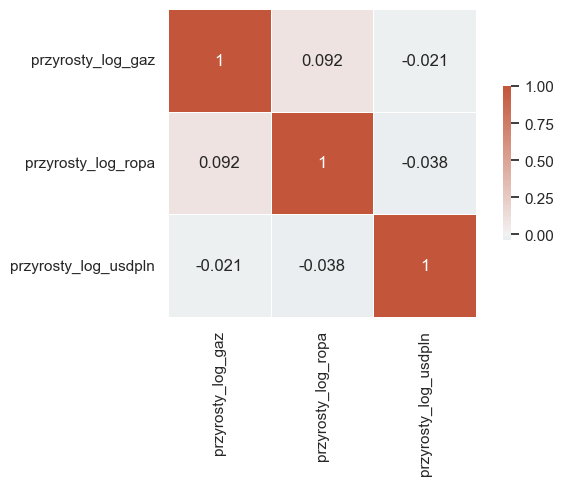

In [146]:
corr2 = df_moved.corr()

f, ax = plt.subplots(figsize=(7, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr2, 
            cmap=cmap,
            annot=True,
            center=0,
            vmax=1,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

### Wniosek:
Zwiększanie różnicy w dniach daje coraz słabszą korelację

## Model jednowskaźnikowy

In [157]:
def jednowskaznikowy(R, Rs):
    lr = LinearRegression()

    lr.fit(np.expand_dims(Rs, axis=1), np.expand_dims(R, axis=1))

    beta, alpha= lr.coef_[0, 0], lr.intercept_[0]
    determinacja = beta **2 * np.var(Rs) / np.var(R)
    war_res = np.sum((R - alpha - beta * Rs) ** 2) / ( len(R) -1)
    
    nazwy = ['alpha_i', 'beta_i', 'Współczynnik determinacji', 'Wariancja residuów']
    wartości = [alpha, beta, determinacja, war_res]
    
    plt.scatter(Rs, R, color="#13C6EB")
    plt.plot([min(Rs), max(Rs)], [beta * min(Rs) + alpha, beta * max(Rs) + alpha], color="#F43D64")
    
    return pd.DataFrame({'Parametr':nazwy, 'Wartość':wartości})

,Parametr,Wartość
0,alpha_i,-0.0003
1,beta_i,-0.1246
2,Współczynnik determinacji,0.0004
3,Wariancja residuów,0.0016


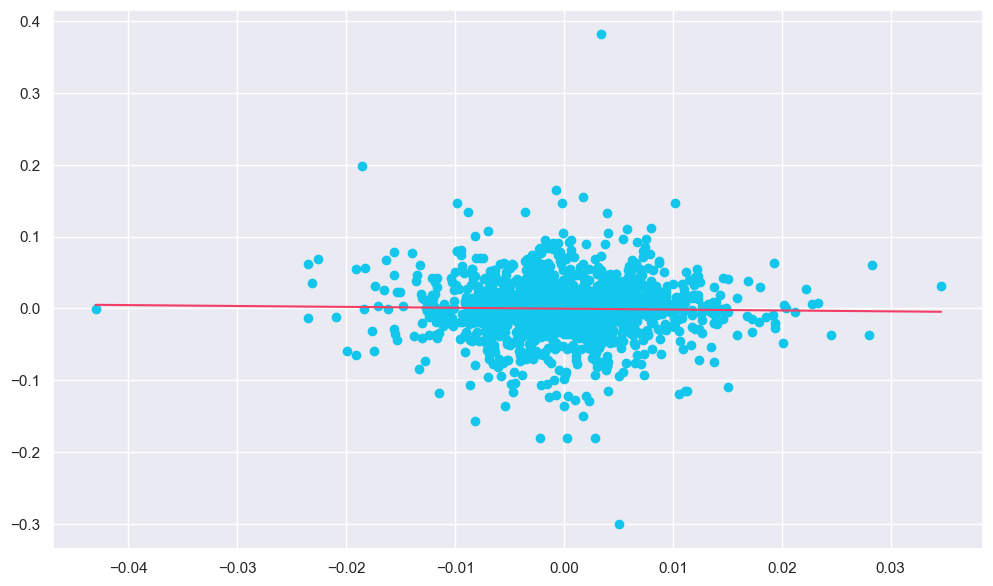

In [158]:
lr_gaz = jednowskaznikowy(df_final['przyrosty_log_gaz'], df_final['przyrosty_log_usdpln'])
lr_gaz

,Parametr,Wartość
0,alpha_i,0.0003
1,beta_i,-0.1589
2,Współczynnik determinacji,0.0015
3,Wariancja residuów,0.0007


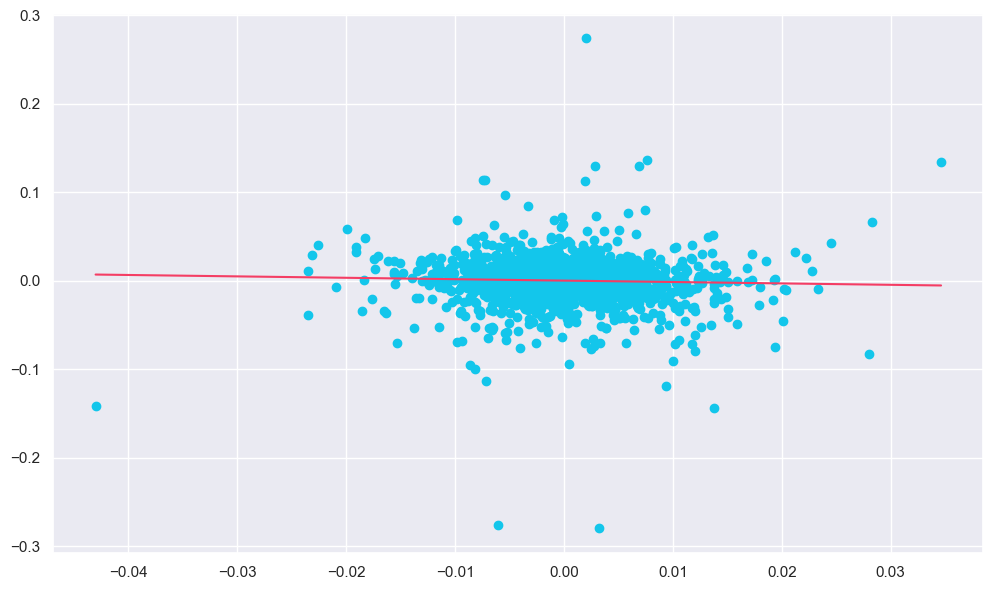

In [159]:
lr_ropa = jednowskaznikowy(df_final['przyrosty_log_ropa'], df_final['przyrosty_log_usdpln'])
lr_ropa

### Estymacja parametrów modelu

In [153]:
alpha_gaz = lr_gaz.iloc[0, 1]
beta_gaz = lr_gaz.iloc[1, 1]
alpha_ropa = lr_ropa.iloc[0, 1]
beta_ropa = lr_ropa.iloc[1, 1]

nazwy = ['alpha_gaz', 'beta_gaz', 'alpha_ropa', 'beta_ropa']
wartości = [alpha_gaz, beta_gaz, alpha_ropa, beta_ropa]
df_lr_coef = pd.DataFrame({'Parametr':nazwy, 'Wartość':wartości})
df_lr_coef

,Parametr,Wartość
0,alpha_gaz,-0.0003
1,beta_gaz,-0.1246
2,alpha_ropa,0.0003
3,beta_ropa,-0.1589


### Wrażliwość - miara oczekiwanej zmiany $R_i$ przy zmianie $R_s$ = $\beta_i$

### Podstawienie do równania

In [172]:
# gaz
residua_gaz =  df_final['przyrosty_log_gaz'] - alpha_gaz - beta_gaz * df_final['przyrosty_log_usdpln']
a_gaz = alpha_gaz + residua_gaz

# ropa
residua_ropa =  df_final['przyrosty_log_ropa'] - alpha_ropa - beta_ropa * df_final['przyrosty_log_usdpln']
a_ropa = alpha_ropa + residua_ropa

### Czy residua w modelu są skorelowane?

### Statystyki zmiennych ryzyka - średnia, odchylenie, korelacja